# 用Adversarial density-ratio estimation估计KL的学习
Given a convex function $f$ for which $f(1) = 0$, the $f-$divergence between $p_x$ and $p_y$ is defined as
$$D_f(p_x||p_y) = \int f({\frac{p_x(x)}{p_y(x)}}) p_x(x)dx$$
For example, the choice $f(t) = tlog t$ corresponds to $D_f (p_{x}p_y) = D_{KL}(p_{x}p_y)$. Given samples
from $p_x$ and $p_y$ we can estimate the $f-$divergence using the density-ratio trick , popularized
recently through the generative adversarial network (GAN) framework. The trick is to express
$p_x$ and $p_y$ as conditional distributions, conditioned on a label $c \in \{0, 1\}$, and reduce the task to
binary classification. In particular, let $p_x(x) = p(x|c = 1)$, $p_y(x) = p(x|c = 0)$, and consider a
discriminator $Sη$ trained to predict the probability that its input is a sample from distributions px
rather than py, i.e, predict $p(c = 1|x)$. The density ratio can be expressed as
$$\frac{p_x(x)}{p_y(x)} = \frac{p(x|c = 1)}{p(x|c = 0)} = \frac{p(c = 1|x)}{p(c = 0|x)} = \frac{Sη(x)}{1-Sη(x)}$$
where the second equality follows from Bayes’ rule under the assumption that the marginal class
probabilities are equal. As such, given N i.i.d. samples $\{x^{(i)}\}^N_{i=1}$ from $p_x$ and a trained classifier$Sη$ one can estimate the KL-divergence by simply computing
$$D_{KL}(p_x(x)||p_y(x)) = \frac{1}{N}\sum_{i=0}^{N}log\frac{Sη(x^{(i)})}{1-Sη(x^{(i)})}$$
As a practical alternative, some approaches replace the KL term in (1) with an arbitrary divergence
(e.g., maximum mean discrepancy). Note, however, that the resulting objective does not necessarily
lower-bound the marginal log-likelihood of the data.
![image](Images/2019_3_13_1.png)

现在，我们假设要估计的两个分布是高斯分布，均值方差如下：

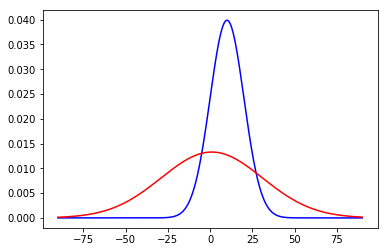

In [28]:
import numpy as np
import matplotlib.pyplot as plt
mu1 = 10
sigma1 = 10
mu2 = 1
sigma2 = 30
x = np.linspace(-90,90,1000)
y1 = 1/(np.sqrt(2*np.pi)*sigma1)*np.exp(-0.5*(x-mu1)**2/sigma1**2)
y2 = 1/(np.sqrt(2*np.pi)*sigma2)*np.exp(-0.5*(x-mu2)**2/sigma2**2)
plt.plot(x,y1,'b')
plt.plot(x,y2,'r')
plt.show()

## 理论计算两个高斯分布的KL散度
如果两个分布都是高斯分布，kl散度可以使用下面的公式计算:
$$ D_{KL}(p_1||p_2) = log\frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$

In [46]:
KL = np.log(sigma2/sigma1) + (sigma1**2+(mu1-mu2)**2)/(2*sigma2**2) - 0.5
print(KL)

0.6991678442236653


In [30]:
#接下来对两个分布进行采样
import torch
e1 = np.random.normal(size=1000)
s1 = mu1 + e1*sigma1
e2 = np.random.normal(size=1000)
s2 = mu2 + e2*sigma2

我们建立一个两层的神经网络来模拟一个判别器

In [31]:
import torch.nn as nn
import torch.nn.init as init
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)
class Discriminator(nn.Module):
    """Model proposed in understanding beta-VAE paper(Burgess et al, arxiv:1804.03599, 2018)."""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),               # B, 256
            nn.ReLU(True),
            nn.Linear(100, 1),                 # B, 256
            nn.Sigmoid(),
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)
    def forward(self, x):
        v = self.layers(x)
        return v

In [32]:
x = np.concatenate((s1,s2))
y = np.concatenate((np.array([1]*1000),np.array([0]*1000)))
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(y)
x = torch.FloatTensor(x).unsqueeze(1)
y = torch.FloatTensor(y).unsqueeze(1)
def return_data(it):
    return x[100*(it-1):it*100,:],y[100*(it-1):it*100]

In [41]:
from tqdm import tqdm
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
net = Discriminator()
criterion = nn.BCELoss()
def train():
    optimizer = optim.Adam(net.parameters(), lr=10e-4,
                                    betas=(0.9, 0.99))
    print("training start!!!")
    global_iter = 0
    it = 1
    pbar = tqdm(total=5000)
    pbar.update(global_iter)
    for i in range(5000):
        x_,y_ = return_data(it)
        pbar.update(1)
        if it == 10:
            it = 1
        else:
            it += 1
        global_iter += 1
        x_ = Variable(x_)
        y_ = Variable(y_)
        value = net(x_)
        adv_loss = criterion(value,y_)
        optimizer.zero_grad()
        adv_loss.backward()
        optimizer.step()
    pbar.close()

C:\Users\v-tayan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


In [47]:
train()

training start!!!



100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2537.42it/s]

In [48]:
index = net(x)
(index/(1-index)).log().sum()/2000

tensor(-1.1185, grad_fn=<DivBackward0>)